# Team MovieGnat
## Milestone 4
## Deep Learning

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'1.0.1'

In [5]:
import requests
import json
import time
import itertools
import wget
import os
import pickle

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import precision_recall_curve
import scipy

sns.set_style('white')

import tensorflow as tf
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model

# image processing 
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from scipy.misc import imresize
import matplotlib.image as mpimg
import io
import urllib

Using TensorFlow backend.


In [6]:
keras.__version__

'2.0.2'

In [7]:
import warnings
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /gpu:0


# Load Data

In [8]:
############# FOR AWS: Read in data FROM GITHUB ################

train = pd.read_csv('https://raw.githubusercontent.com/nikhilaravi/movies/master/data/train_data_with_sampling.csv')
test = pd.read_csv('https://raw.githubusercontent.com/nikhilaravi/movies/master/data/test_data.csv')

############# Convert to test and train set ################

X_train_ids = train[['tmdb_id']].values
y_train = train[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']].as_matrix()
X_test_ids = test[['tmdb_id']].values
y_test = test[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']].as_matrix()

############## Function to read poster image from github given tmdb id ###################

def loadImageFromId(tmdb_id):
    url = 'https://raw.githubusercontent.com/nikhilaravi/movies/master/posters/' + tmdb_id + '.jpg'
    file = io.BytesIO(urllib.request.urlopen(url).read())
    img = Image.open(file)
    return img

############# Load in posters ################

def load_posters_from_ids(id_array, n, y):
    Y = y
    posters = []
    ids = []
    errors = 0
    
    for poster in id_array:
        
        # uncomment this line if running on AWS 
        img = loadImageFromId(str(int(poster[0])))
        
        try:
            # original scale 500 x 741 but need to reduce resolution 
            scaled = img.resize(size=(100, int(741/5)))
            posters.append(np.asarray(scaled))
            ids.append(poster)
            
        except ValueError:
            errors +=1
            continue
            
    posters_array = np.asarray(posters)
    X = np.array(posters_array)
    
    print ('posters shape: ', X.shape)
    print ('errors: ', errors)
    
    # rescale pixel values
    return X/255, Y

In [9]:
#### load testing and training data 
X_train, Y_train = load_posters_from_ids(X_train_ids, 500, y_train)
X_test, Y_test = load_posters_from_ids(X_test_ids, 100, y_test)

posters shape:  (7814, 148, 100, 3)
errors:  0
posters shape:  (3700, 148, 100, 3)
errors:  0


# 1. CNN from scratch

First we build a basic CNN from scratch using an arbitrarily chosen design with 3 Conv-Pool layers, and a fully connected network at the end with 1 hidden layer.

### Build and compile basic CNN

In [9]:
# Build and compile CNN

from keras.callbacks import TensorBoard

log_dir_string = "cv"

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(X_train.shape[1], X_train.shape[2], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
log_dir_string += "_1conv"

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
log_dir_string += "_2conv"

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
log_dir_string += "_3conv"

model.add(Flatten())
model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
log_dir_string += "_1fc"

model.add(Dense(units=7, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer='adam')

tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string, histogram_freq=1, write_graph=True, write_images=False)

In [ ]:
# Fit model
batch_size = 16
epochs = 20

model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[tensorboard])

Epoch 1/20
7814/7814 [==============================] - 9s - loss: 3.6081      

### Define error measures

After fitting the model, we define three different error measures, similar to the previous milestone. As this is a multi-label problem, we use the error measures:
- Hamming Loss
- Percent exact match
- Percent at least one label matches

In [20]:
# Define three different error measures to compare our models

from sklearn.metrics import hamming_loss

def error_measures(ypred, ytest):
    ypred = np.array(ypred)
    ytest = np.array(ytest)
    
    # Hamming loss
    h_loss = hamming_loss(ytest, ypred)

    # Percent exact matches
    y_pred_str = np.array([str(yi) for yi in ypred])
    y_test_str = np.array([str(yi) for yi in ytest])
    percent_exact = np.sum(y_pred_str == y_test_str) * 1. / ytest.shape[0]
    
    # Percent at least one match (at least one of the genres are both 1)
    atleastone_count = 0
    for ind in range(len(ypred)):
        yi_pred = ypred[ind]
        yi_test = ytest[ind]
        for i in range(len(yi_pred)):
            if yi_pred[i] == 1 and yi_test[i] == 1:
                atleastone_count += 1
                break
    percent_atleastone = atleastone_count * 1. / ytest.shape[0]
    
    return h_loss, percent_exact, percent_atleastone

### Make predictions

In [15]:
# Make predictions on the test set
y_pred_proba = model.predict(X_test, batch_size=batch_size)

# Predict after casting probabilities to labels
y_pred = []
for yi in y_pred_proba:
    yi_new = np.array([1 if yii >= 0.5 else 0 for yii in yi])
    y_pred.append(yi_new)
y_pred = np.array(y_pred)

# compute error measures

h_loss, percent_exact, percent_atleastone = error_measures(y_pred, Y_test)
print ('CNN error measures \n=====================\n')
print ('Hamming Loss: ', h_loss)
print ('Percent exact: ', percent_exact)
print ('Percent at least one: ', percent_atleastone)

CNN error measures 

Hamming Loss:  0.15355212355212355
Percent exact:  0.438648648649
Percent at least one:  0.9481081081081081


We get pretty good results here. These results are even similar to those with metadata (and run with SVM, RF and ANN in our previous milestone). As a next step, we can use grid search to fine-tune our CNN from scratch.

### Grid search to fine-tune our CNN

In [ ]:
# Let's use grid search to fine tune our network

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import TensorBoard
from keras import metrics

def build_classifier(optimizer, n_features):
    log_dir_string = "cv" + str(optimizer) + str(n_features)
    model = Sequential()
    model.add(Conv2D(n_features, (3,3), input_shape=(X_train.shape[1], X_train.shape[2], 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(n_features, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(n_features*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(units=n_features*2, kernel_initializer='uniform', activation='relu'))

    model.add(Dense(units=7, kernel_initializer='uniform', activation='sigmoid'))

    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer, metrics = [metrics.mae, metrics.categorical_accuracy])
    
    tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string, histogram_freq=1, write_graph=True, write_images=False)
    return model

classifier = KerasClassifier(build_fn=build_classifier)
parameters = {'batch_size': [16,32],
              'epochs': [20,50],
              'optimizer': ['adam','rmsprop'],
              'n_features': [64,128]}
grid_search = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=4, verbose=False)
grid_search = grid_search.fit(X_train, Y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Epoch 1/20
5860/5860 [==============================] - 12s - loss: 4.9851 - mean_absolute_error: 0.4253 - categorical_accuracy: 0.4520         

After running grid search (and crashing multiple times on our CNN), we found reasonable set of params that we do better. A couple changes and their justifications:

- We learned that more neurons/feature detectors with dropout is more effective than just less neurons.
- Adam optimizer and rmsprop do not make a difference
- Categorical crossentropy seem to slightly outperform binary crossentropy when it comes to multi-label predictions
- The number of epochs past 20 doesn't improve performance too much. We were surprised at this because 20 epochs seem low, but it seems it's good enough given our small size of data.

### Fine tuned CNN from scratch

In [22]:
# Build and compile tuned CNN

from keras.callbacks import TensorBoard

log_dir_string = "cv-tuned"

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(X_train.shape[1], X_train.shape[2], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.2))
log_dir_string += "_1conv"

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
log_dir_string += "_2conv"

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
log_dir_string += "_3conv"

model.add(Flatten())
model.add(Dense(units=128, kernel_initializer='uniform', activation='relu'))
log_dir_string += "_1fc"
model.add(Dropout(0.2))
model.add(Dense(units=7, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = [metrics.mae, metrics.categorical_accuracy])

tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string, histogram_freq=1, write_graph=True, write_images=False)

In [ ]:
# Fit model
batch_size = 16
epochs = 20

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[tensorboard])

INFO:tensorflow:Summary name conv2d_10/kernel:0 is illegal; using conv2d_10/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_10/bias:0 is illegal; using conv2d_10/bias_0 instead.
INFO:tensorflow:Summary name conv2d_11/kernel:0 is illegal; using conv2d_11/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_11/bias:0 is illegal; using conv2d_11/bias_0 instead.
INFO:tensorflow:Summary name conv2d_12/kernel:0 is illegal; using conv2d_12/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_12/bias:0 is illegal; using conv2d_12/bias_0 instead.
INFO:tensorflow:Summary name dense_7/kernel:0 is illegal; using dense_7/kernel_0 instead.
INFO:tensorflow:Summary name dense_7/bias:0 is illegal; using dense_7/bias_0 instead.
INFO:tensorflow:Summary name dense_8/kernel:0 is illegal; using dense_8/kernel_0 instead.
INFO:tensorflow:Summary name dense_8/bias:0 is illegal; using dense_8/bias_0 instead.
Epoch 1/20
7814/7814 [==============================] - 16s - loss: 4.9975 - mean_absolute_error

In [24]:
# Make predictions on the test set
y_pred_proba = model.predict(X_test, batch_size=batch_size)

# Predict after casting probabilities to labels
y_pred = []
for yi in y_pred_proba:
    yi_new = np.array([1 if yii >= 0.5 else 0 for yii in yi])
    y_pred.append(yi_new)
y_pred = np.array(y_pred)

# compute error measures

h_loss, percent_exact, percent_atleastone = error_measures(y_pred, Y_test)
print ('CNN error measures \n=====================\n')
print ('Hamming Loss: ', h_loss)
print ('Percent exact: ', percent_exact)
print ('Percent at least one: ', percent_atleastone)

CNN error measures 

Hamming Loss:  0.13096525096525097
Percent exact:  0.497837837838
Percent at least one:  0.957027027027027


**As you can see hamming loss fell from 0.15 to 0.13, percent exact increased from 0.44 to 0.50, and percent at least one increased slightly! We have fine tuned our CNN using grid search.**

# 3. VGG16 to transfer style from one image to another

In our additional exploration, we read the papers  popular paper (Gatys et al., 2015 - https://arxiv.org/abs/1508.06576) that demonstrates how to use neural networks to transfer artistic style from one image onto another. This is the underlying technology behind the popular Prisma app.

In [6]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np
import io
import urllib
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

### Preprocess images

Here we load the movie poster and a style image that we want to transfer the style over to. We also do a bunch of other preprocessing such as standardizing pixel values with respect to VGG's mean values.

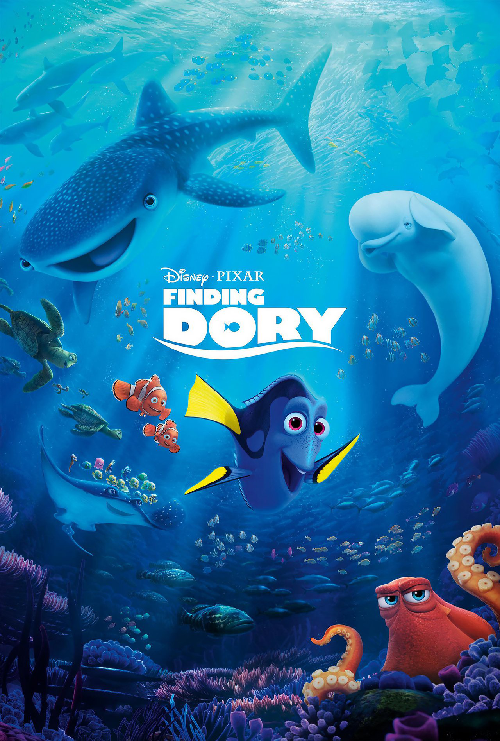

In [46]:
# Load movie poster

height = 741
width = 500
url = 'https://raw.githubusercontent.com/nikhilaravi/movies/master/posters/13813.jpg'
url = 'https://image.tmdb.org/t/p/w1280/z09QAf8WbZncbitewNk6lKYMZsh.jpg'
content_image_path = io.BytesIO(urllib.request.urlopen(url).read())
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

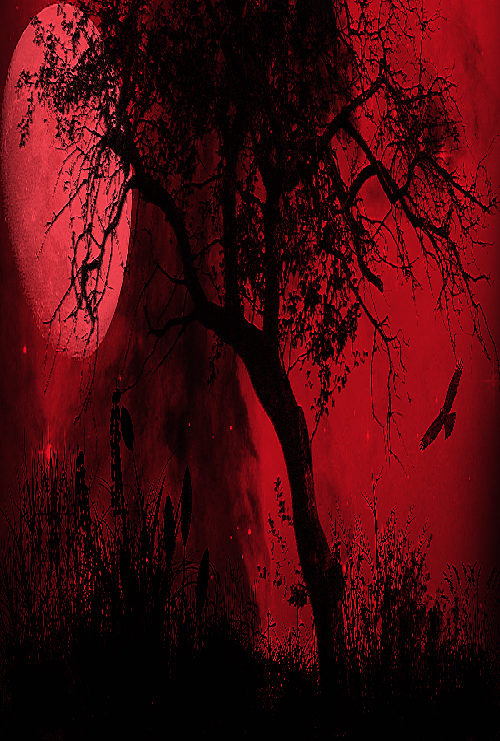

In [45]:
# Load style image: WARNING GORY!

# style_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/The_Scream.jpg/1200px-The_Scream.jpg'
# style_url = 'http://favim.com/orig/201107/12/anime-beyond-birthday-blood-bluelover382-dark-death-note-Favim.com-103095.jpg'
style_url = 'http://wallpaper-gallery.net/images/bloody-wallpaper/bloody-wallpaper-15.jpg'
style_image_path = io.BytesIO(urllib.request.urlopen(style_url).read())
style_image = Image.open(style_image_path)
style_image = style_image.resize((width,height))
style_image

In [47]:
# Add another dimension for processing later

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 741, 500, 3)
(1, 741, 500, 3)


In [48]:
# Standardize pixel values with respect to VGG16 means

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [49]:
# Define Keras variables and initialize combination image

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

# Concatenate into tensor for VGG16
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

### Load VGG16

In [50]:
# Load VGG16

model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_3/Relu:0' shape=(3, 741, 500, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_3/Relu:0' shape=(3, 741, 500, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_3/MaxPool:0' shape=(3, 370, 250, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_3/Relu:0' shape=(3, 370, 250, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_3/Relu:0' shape=(3, 370, 250, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_3/MaxPool:0' shape=(3, 185, 125, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_3/Relu:0' shape=(3, 185, 125, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_3/Relu:0' shape=(3, 185, 125, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_3/Relu:0' shape=(3, 185, 125, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_3/MaxPool:0' shape=(3, 92, 62, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_3/Relu:0' shape=(3, 92, 62, 51

### Define loss functions

The core idea introduced by Gatys et al. (2015) is that CNNs pre-trained for image classification already know how to encode perceptual and semantic information about images. We're use their idea, and take the feature spaces provided by VGG16 to independently work with content and style of images. Since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. We only need the 16 layers in the 'D' column of VGG16.

The crux of the paper we reproduce is that the style transfer problem can be posed as an optimization problem, where the loss function we want to minimise can be decomposed into three distinct parts: the content loss, the style loss and the total variation loss.

In [51]:
# Define initialization weights - chosen arbitrarily.

content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0
loss = backend.variable(0.)

### Content loss

Content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images. We draw the content feature from: block2_conv2 (as stated in the paper). 

In [52]:
### CONTENT LOSS ###

def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### Style loss

To define style loss we first define the gram matrix, which is proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. We then compute the style loss, which is the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images. Style loss is a bit more complicated, and we draw the features from multiple feature layers as mentioned in the paper (block1_conv2, block2_conv2, block3_conv3, block4_conv3, block5_conv3).

In [53]:
### STYLE LOSS ###

# Style loss is a bit more complicated

# Proportional to the covariances of corresponding sets of features, 
# and thus captures information about which features tend to activate together
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

# Style loss is then the (scaled, squared) Frobenius norm of the difference 
# between the Gram matrices of the style and combination images.
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### Total variation loss

Instead of just using style and content loss, we add a total variation loss to regularize content and style loss to encourage spatial smoothness

In [54]:
### TOTAL VARIATION LOSS ###

# Used to regularize content and style loss to encourage spatial smoothness
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

### Optimization

The combination image is initialized as a random collection of pixels, and we use the L-BFGS algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it, while transfering both the content image and style image to it based on the loss functions.

In [55]:
# Define gradients for optimization

grads = backend.gradients(loss, combination_image)
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [56]:
# Perform gradient descent using L-BFGS algorithm

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2.14427e+11
Iteration 0 completed in 29s
Start of iteration 1
Current loss value: 7.11808e+10
Iteration 1 completed in 28s
Start of iteration 2
Current loss value: 4.66434e+10
Iteration 2 completed in 28s
Start of iteration 3
Current loss value: 4.18027e+10
Iteration 3 completed in 28s
Start of iteration 4
Current loss value: 4.03214e+10
Iteration 4 completed in 28s
Start of iteration 5
Current loss value: 3.92412e+10
Iteration 5 completed in 29s
Start of iteration 6
Current loss value: 3.84382e+10
Iteration 6 completed in 29s
Start of iteration 7
Current loss value: 3.78153e+10
Iteration 7 completed in 29s
Start of iteration 8
Current loss value: 3.73142e+10
Iteration 8 completed in 28s
Start of iteration 9
Current loss value: 3.6964e+10
Iteration 9 completed in 29s


### Results

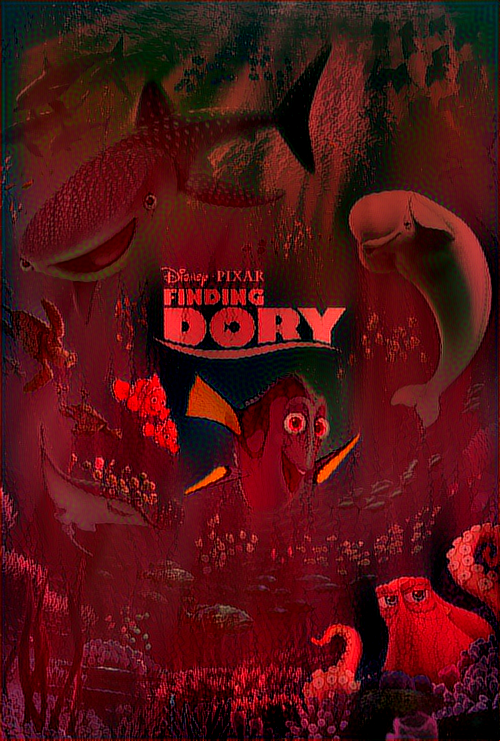

In [58]:
# Display combination image!

x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

We just made Finding Dory a horror movie!